In [27]:
import requests
import pandas as pd 
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
import numpy as np

In [28]:
mensa_suffix = "mg"
from_date = "00:00_20190901"
url = "http://graphite-kom.srv.lrz.de/render?target=transformNull(sumSeries(exclude(ap.ap*-?{mensa}*.ssid.*,\"ssid\\.error$\")))&format=json&from={date}".format(mensa=mensa_suffix, date=from_date)
json = requests.get(url).json()

In [29]:
datapoints = json[0]["datapoints"]

In [58]:
df = pd.DataFrame(datapoints)
df[1], df[0] = df[0], df[1]
df = df.rename(columns={0:"ds",1:"y"})
df

,ds,y
0,1567289700,0.000000
1,1567290600,0.000000
2,1567291500,0.000000
3,1567292400,0.000000
4,1567293300,0.000000
5,1567294200,0.000000
6,1567295100,0.000000
7,1567296000,0.000000
8,1567296900,0.000000
9,1567297800,0.000000


In [59]:
def is_workday(ds):
    return ds.dayofweek < 5

In [60]:
df["ds"] = pd.to_datetime(df["ds"],unit='s')
df["y"] = np.log(df["y"]+1)
df["is_workday"] = df["ds"].apply(is_workday)
df["is_weekend"] = -df["ds"].apply(is_workday)
df

,ds,y,is_workday,is_weekend
0,2019-08-31 22:15:00,0.000000,False,True
1,2019-08-31 22:30:00,0.000000,False,True
2,2019-08-31 22:45:00,0.000000,False,True
3,2019-08-31 23:00:00,0.000000,False,True
4,2019-08-31 23:15:00,0.000000,False,True
5,2019-08-31 23:30:00,0.000000,False,True
6,2019-08-31 23:45:00,0.000000,False,True
7,2019-09-01 00:00:00,0.000000,False,True
8,2019-09-01 00:15:00,0.000000,False,True
9,2019-09-01 00:30:00,0.000000,False,True


In [61]:
max(df["y"])

7.2679905441156265

In [111]:
m = Prophet(changepoint_prior_scale=0.02, daily_seasonality=20, weekly_seasonality=10)
m.add_country_holidays(country_name='DE')
m.add_seasonality(name='on_workdays', period=1, fourier_order=5, condition_name='is_workday')
m.add_seasonality(name='on_weekends', period=1, fourier_order=3, condition_name='is_weekend')
m.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [112]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

In [113]:
future = m.make_future_dataframe(periods=24, freq='H', include_history=False)
future["is_workday"] = future["ds"].apply(is_workday)
future["is_weekend"] = -future["ds"].apply(is_workday)

In [114]:
future.tail()

,ds,is_workday,is_weekend
19,2020-06-26 19:45:00,True,False
20,2020-06-26 20:45:00,True,False
21,2020-06-26 21:45:00,True,False
22,2020-06-26 22:45:00,True,False
23,2020-06-26 23:45:00,True,False


In [115]:
forecast = m.predict(future)

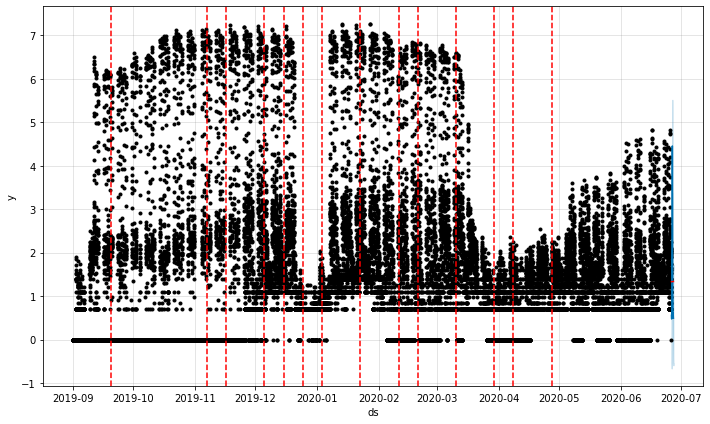

In [116]:
fig1 = m.plot(forecast)
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

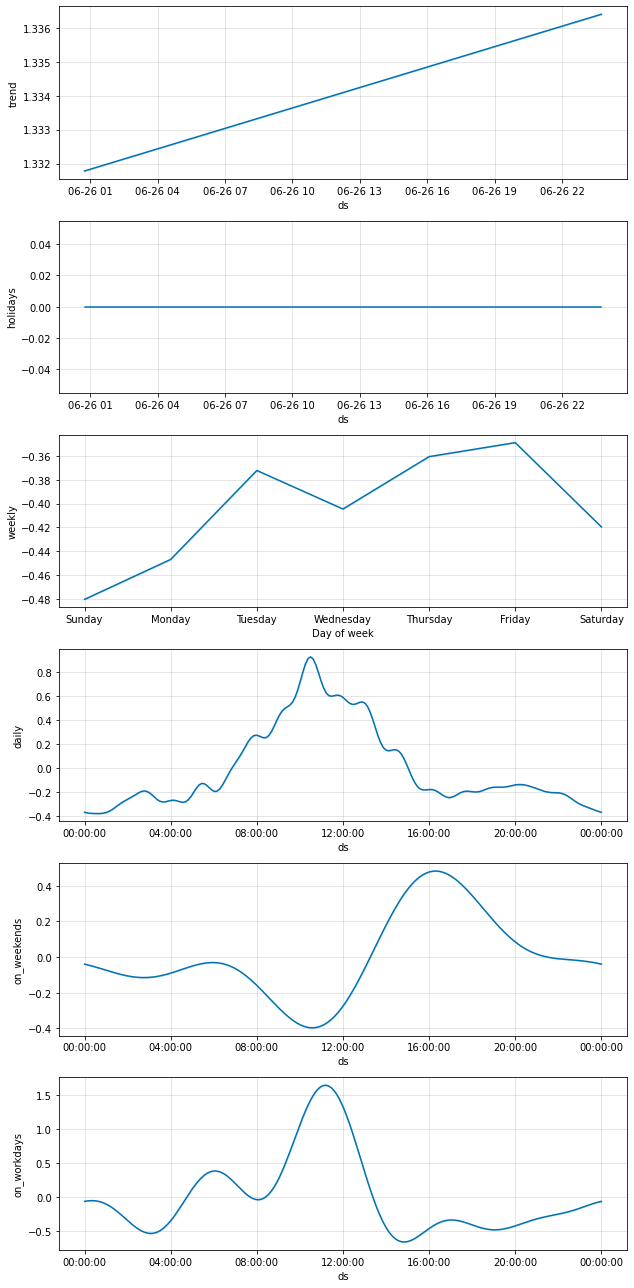

In [117]:
fig2 = m.plot_components(forecast)

In [118]:
future_today = m.make_future_dataframe(periods=672, freq='15T', include_history=False)
future_today["is_workday"] = future_today["ds"].apply(is_workday)
future_today["is_weekend"] = -future_today["ds"].apply(is_workday)
today_forecast = m.predict(future_today)

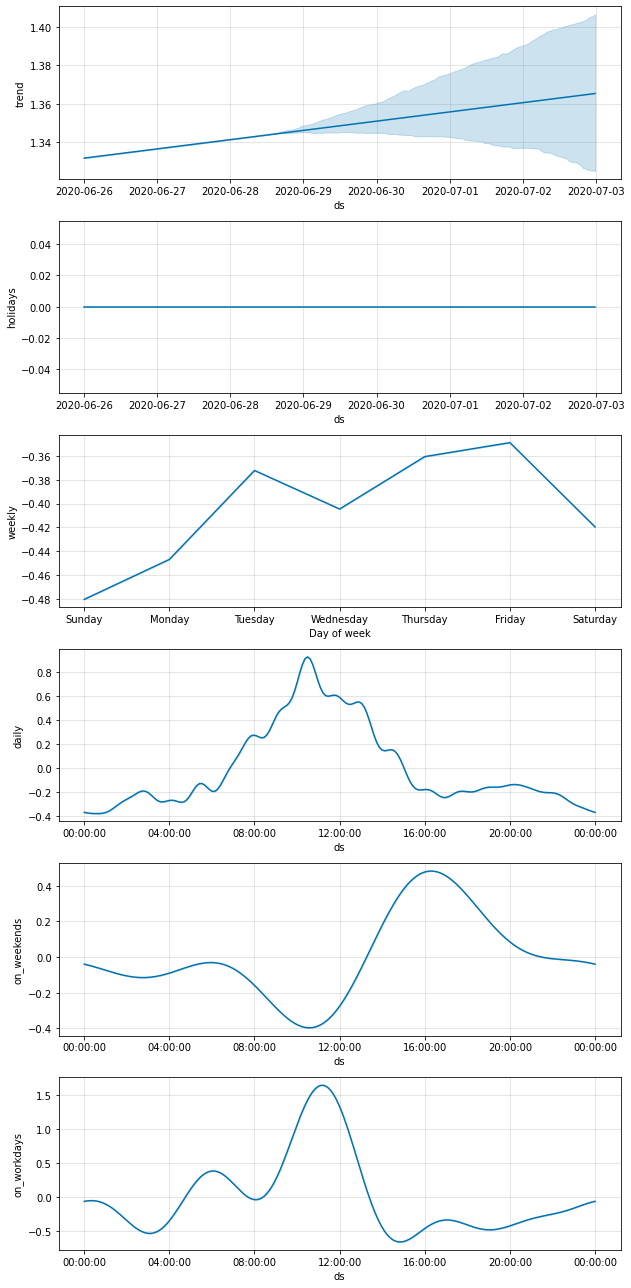

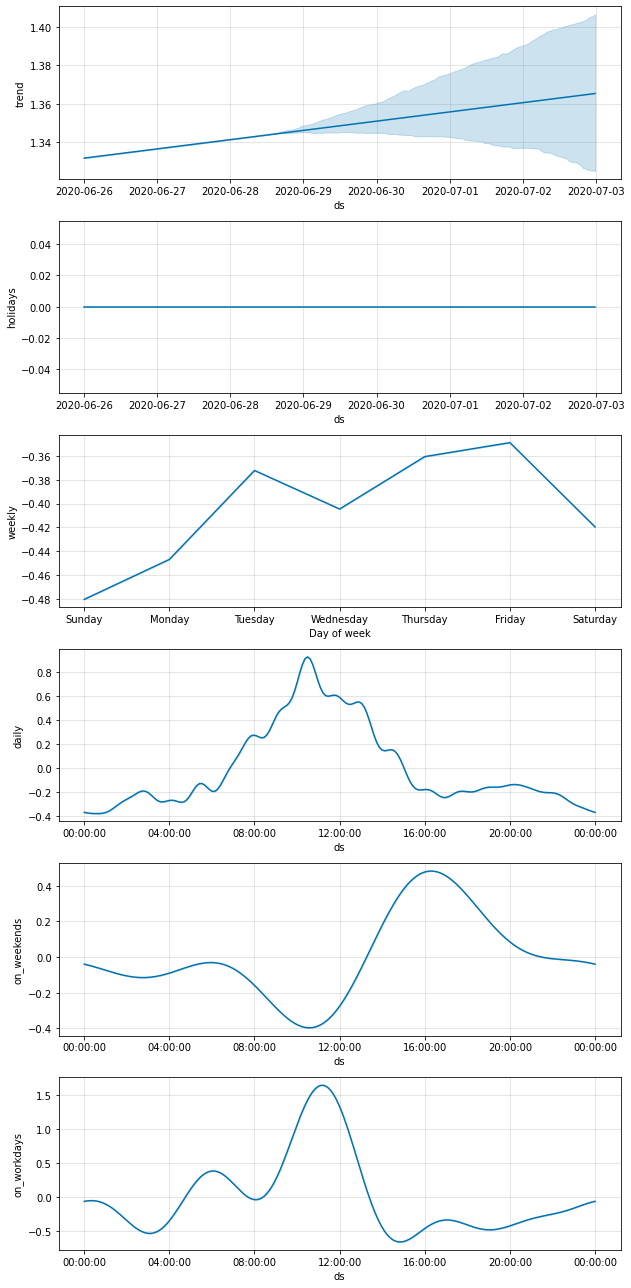

In [119]:
m.plot_components(today_forecast)

In [120]:
today_forecast_only = today_forecast.filter(["ds", "yhat"])
#today_forecast_only.loc[today_forecast_only["yhat"] < 1, "yhat"] = 1
#today_forecast_only["yhat"] = np.exp(today_forecast_only["yhat"] - 1)

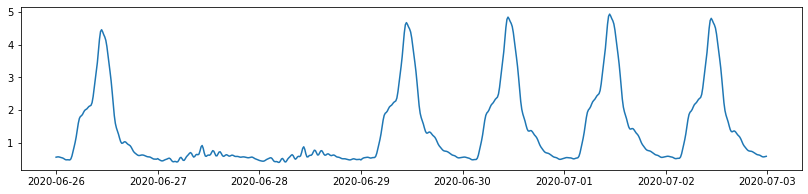

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 3))
plt.plot(today_forecast_only["ds"], today_forecast_only["yhat"])